# Pylops - basic linear operators on GPU with cupy

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops* and test both their numpy and cupy backends.

In [1]:
!nvidia-smi

Sat Sep 19 16:49:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install cupy-cuda101
!pip install cupy-cuda101==8.0.0rc1 --upgrade
#!pip install pylops[advanced]
!pip install git+https://github.com/mrava87/pylops@cupy-ext

     |████████████████████████████████| 114.9MB 96kB/s 
  Found existing installation: cupy-cuda101 7.4.0
    Uninstalling cupy-cuda101-7.4.0:
      Successfully uninstalled cupy-cuda101-7.4.0
  Cloning https://github.com/mrava87/pylops (to revision cupy-ext) to /tmp/pip-req-build-uf90alen
  Running command git clone -q https://github.com/mrava87/pylops /tmp/pip-req-build-uf90alen
  Running command git checkout -b cupy-ext --track origin/cupy-ext
  Switched to a new branch 'cupy-ext'
  Branch 'cupy-ext' set up to track remote branch 'cupy-ext' from 'origin'.
  Created wheel for pylops: filename=pylops-1.10.1.dev38+g196c4b9-cp36-none-any.whl size=154382 sha256=cb801bb9d7a74ec0cc3c5c1ab4aabad16f759e73f2cfb35625d7884a59b14495
  Stored in directory: /tmp/pip-ephem-wheel-cache-c2mg_aqq/wheels/ee/c6/91/602ea68e6c612f7b41703971525d62bc6270318ac1e29433fa
Successfully built pylops


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt

from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.optimization.solver import cgls
from pylops.optimization.leastsquares import *

In [4]:
cp.__version__

'8.0.0rc1'

# Matrix Multiplication

Create operator simply overloading a numpy/cupy matrix $\mathbf{A}$

$$\mathbf{y}=  \mathbf{A} \mathbf{x}$$

In [5]:
ny, nx = 4, 4
G = np.random.normal(0,1,(ny,nx))
x = np.ones(nx)

Gop = MatrixMult(G, dtype='float64')
dottest(Gop, ny, nx)

print('eigs=',Gop.eigs())
print('Ginv=',Gop.inv())

y=Gop*x
print('y=',y)

xest = Gop / y
xlsqr, istop, itn, r1norm, r2norm = lsqr(Gop, y, damp=1e-10, iter_lim=100, show=0)[0:5]
xcgls, itn, cost = cgls(Gop, y, x0=np.zeros(nx), niter=100, tol=1e-10, show=True)

print('x=',x)
print('direct inversion xest=', xest)
print('lsqr solution xest=', xlsqr)
print('cgls solution xest=', xcgls)

eigs= [-0.05131266+0.j         -0.56311464+1.42926925j -0.56311464-1.42926925j
 -1.87036967+0.j        ]
Ginv= [[ -4.96350283  -0.73792161  -2.50026868  -7.88010786]
 [ -9.17993632  -1.1526386   -5.45833176 -16.87356351]
 [ -2.846315     0.57350328  -1.98132921  -5.31928878]
 [ -6.71728811  -0.89741752  -3.57860196 -12.40278506]]
y= [-1.02704834  1.00549922  0.79950542  0.1721803 ]
CGLS
-----------------------------------------------------------
The Operator Op has 4 rows and 4 cols
damp = 0.000000e+00	tol = 1.000000e-10	niter = 100
-----------------------------------------------------------------
    Itn           x[0]              r2norm
     1         1.8270e-01         1.8136e+00
     2         4.5421e-01         7.0048e-02
     3         3.4681e-01         6.1422e-06
     4         1.0000e+00         2.4364e-22

Iterations = 4        Total time (s) = 0.00
-----------------------------------------------------------------

x= [1. 1. 1. 1.]
direct inversion xest= [1. 1. 1. 1.]
lsqr s

In [6]:
ny, nx = 4, 4
G = cp.random.normal(0,1,(ny, nx))
x = cp.ones(nx)

Gop = MatrixMult(G, dtype='float64')
dottest(Gop, ny, nx, backend='cupy')

#print('eigs=',Gop.eigs())
#print('Ginv=',Gop.inv())

y=Gop*x
print('y=',y)

xest = Gop / y
xcgls, itn, cost = cgls(Gop, y, x0=cp.zeros(nx), niter=100, tol=1e-10, show=True)

print('x=',x)
print('direct inversion xest=', xest)
print('cgls solution xest=', xcgls)

y= [ 0.87385206 -1.20786131 -5.67146756  2.26532712]
CGLS
-----------------------------------------------------------
The Operator Op has 4 rows and 4 cols
damp = 0.000000e+00	tol = 1.000000e-10	niter = 100
-----------------------------------------------------------------
    Itn           x[0]              r2norm
     1         6.8683e-02         3.6742e+00
     2         4.1060e-01         1.6845e-01
     3         3.4442e-01         5.1235e-03
     4         1.0000e+00         1.6475e-21

Iterations = 4        Total time (s) = 1.14
-----------------------------------------------------------------

x= [1. 1. 1. 1.]
direct inversion xest= [1. 1. 1. 1.]
cgls solution xest= [1. 1. 1. 1.]


Let's see how this compares for a large problem in terms of timing

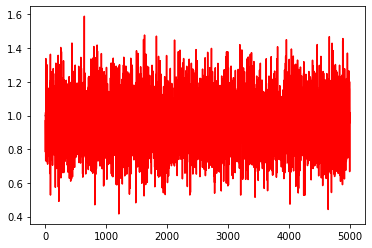

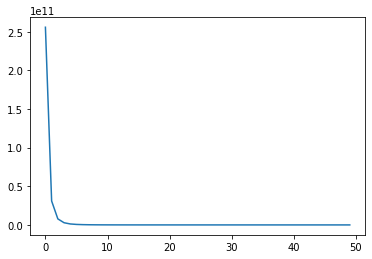

In [7]:
ny, nx = 5000, 5000
G = np.random.normal(0,1,(ny,nx)).astype(np.float32)
x = np.ones(nx, dtype=np.float32)

Gop = MatrixMult(G, dtype='float32')
y = Gop * x

xcgls, itn, cost = cgls(Gop, y, x0=np.zeros(nx, dtype=np.float32), 
                        niter=50, tol=1e-10, show=False)

plt.figure()
plt.plot(x, 'k')
plt.plot(xcgls, 'r')

plt.figure()
plt.plot(cost);

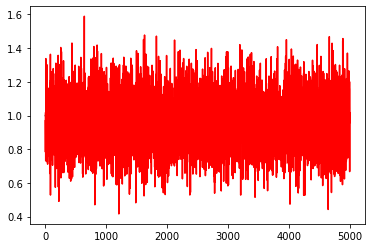

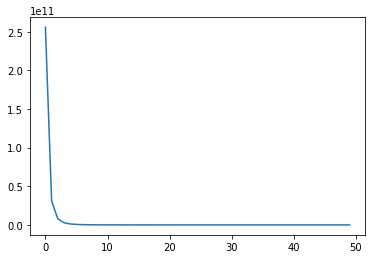

In [8]:
Gc = cp.asarray(G)
xc = cp.ones(nx, dtype=np.float32)

Gcop = MatrixMult(Gc, dtype='float32')
yc = Gcop * xc

xcgls, itn, cost = cgls(Gcop, yc, x0=cp.zeros(nx, dtype=np.float32), 
                        niter=50, tol=1e-10, show=False)

plt.figure()
plt.plot(x, 'k')
plt.plot(cp.asnumpy(xcgls), 'r')

plt.figure()
plt.plot(cost);

In [9]:
%timeit -n 3 -r 2 cgls(Gop, y, x0=np.zeros(nx, dtype=np.float32), niter=50, tol=1e-10, show=False)
%timeit -n 3 -r 2 cgls(Gcop, yc, x0=cp.zeros(nx, dtype=np.float32), niter=50, tol=1e-10, show=False)

3 loops, best of 2: 656 ms per loop
3 loops, best of 2: 57.5 ms per loop


# Identity

Apply identity operator. The forward is
$$\mathbf{y} = \mathbf{I}\mathbf{x}=\mathbf{x}$$

and the adjoint is
$$\mathbf{x} = \mathbf{I}\mathbf{y}=\mathbf{y}$$

In [10]:
ny, nx = 5, 5 
x   = cp.arange(nx)
Iop = Identity(ny, nx)
dottest(Iop, ny, nx, verb=True, backend='cupy')

y  = Iop*x
y1 = Iop.H*x

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=-3.292521 - u^T(Op^Tv)=-3.292521
x  =  [0 1 2 3 4]
I*x  =  [0 1 2 3 4]
I'*x =  [0 1 2 3 4]


In [11]:
ny, nx = 5, 7
x   = cp.arange(nx)
Iop = Identity(ny, nx)
dottest(Iop, ny, nx, verb=True, backend='cupy')

y  = Iop*x
y1 = Iop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=-0.340499 - u^T(Op^Tv)=-0.340499
x  =  [0 1 2 3 4 5 6]
I*x  =  [0 1 2 3 4]
I'*x =  [0. 1. 2. 3. 4. 0. 0.]


In [12]:
ny, nx = 7, 5 
x   = cp.arange(nx)
Iop = Identity(ny, nx)
dottest(Iop, ny, nx, verb=True, backend='cupy')

y  = Iop*x
y1 = Iop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=0.845427 - u^T(Op^Tv)=0.845427
x  =  [0 1 2 3 4]
I*x  =  [0. 1. 2. 3. 4. 0. 0.]
I'*x =  [0. 1. 2. 3. 4.]


# Diagonal

We can also perform an element wise multiplation between the input array $\mathbf{x}$ and another array $\mathbf{d}$:

$$y_i = d_i x_i  \quad \forall i=1,2,...,N$$

This is equivalent to a matrix-vector multiplication with a matrix containing the vector $\mathbf{d}$ along its main diagonal.

In [13]:
x   = cp.ones(10)
d   = cp.arange(10)
Dop = Diagonal(d)
dottest(Dop,10,10,verb=True, backend='cupy')

y  = Dop*x
y1 = Dop.H*x
y1 = Dop / y

print('D*x  = ',y)
print('D\'*x = ',y1)

Dot test passed, v^T(Opu)=4.327768 - u^T(Op^Tv)=4.327768
D*x  =  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
D'*x =  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
x   = cp.ones((3,5))
d   = cp.ones(15).reshape(3,5)
d[1:] = 0   
Dop = Diagonal(d)
dottest(Dop,15,15,verb=True, backend='cupy')

y  = Dop*x.ravel()
y1 = Dop.H*x.ravel()
y1 = Dop / x.ravel()

print('D*x  = ',y.reshape(3,5))
print('D\'*x = ',y1.reshape(3,5))

Dot test passed, v^T(Opu)=-1.751024 - u^T(Op^Tv)=-1.751024
D*x  =  [[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
D'*x =  [[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [15]:
# Complex numbers
x   = cp.ones((3,5))
d   = cp.ones(15).reshape(3,5) + 1j*cp.ones(15).reshape(3,5)
d[1:] = 0   
Dop = Diagonal(d)
dottest(Dop,15,15, verb=True, complexflag=2, backend='cupy')

y  = Dop*x.ravel()
y1 = Dop.H*x.ravel()
y1 = Dop / y

print('D*x  = ',y.reshape(3,5))
print('D\'*x = ',y1.reshape(3,5))

Dot test passed, v^T(Opu)=0.691526+0.628263i - u^T(Op^Tv)=0.691526+0.628263i
D*x  =  [[1.+1.j 1.+1.j 1.+1.j 1.+1.j 1.+1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
D'*x =  [[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [16]:
x  = np.ones(15) + 1j*np.ones(15)
x.dot(x.conj())

(30+0j)

# Zero

Apply zero operator. The forward is
$$\mathbf{y} = \mathbf{0}\mathbf{x}=\mathbf{0}_{N_y}$$

and the adjoint is
$$\mathbf{x} = \mathbf{0}\mathbf{y}=\mathbf{0}_{N_x}$$

In [17]:
ny, nx = 5, 5
x   = cp.arange(nx)
Zop = Zero(ny, nx)
dottest(Zop, ny, nx, verb=True, backend='cupy')

y  = Zop*x
y1 = Zop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=0.000000 - u^T(Op^Tv)=0.000000
x  =  [0 1 2 3 4]
I*x  =  [0. 0. 0. 0. 0.]
I'*x =  [0. 0. 0. 0. 0.]


In [18]:
ny, nx = 7, 5
x   = cp.arange(nx)
Zop = Zero(ny, nx)
dottest(Zop, ny, nx, verb=True, backend='cupy')

y  = Zop*x
y1 = Zop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=0.000000 - u^T(Op^Tv)=0.000000
x  =  [0 1 2 3 4]
I*x  =  [0. 0. 0. 0. 0. 0. 0.]
I'*x =  [0. 0. 0. 0. 0.]


In [19]:
ny, nx = 5, 7
x   = cp.arange(nx)
Zop = Zero(ny, nx)
dottest(Zop, ny, nx, verb=True, backend='cupy')

y  = Zop*x
y1 = Zop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=0.000000 - u^T(Op^Tv)=0.000000
x  =  [0 1 2 3 4 5 6]
I*x  =  [0. 0. 0. 0. 0.]
I'*x =  [0. 0. 0. 0. 0. 0. 0.]


# Sum

In [20]:
ny, nx = 5, 7
x   = (cp.arange(ny*nx)).reshape(ny, nx)
Sop = Sum(dims=(ny, nx), dir=0)
dottest(Sop, nx, ny*nx, verb=True, backend='cupy')

y  = Sop*x.ravel()
xadj = Sop.H*y
xinv = Sop / y

xadj = xadj.reshape(ny, nx)
xinv = xinv.reshape(ny, nx)

print('x  = ',x)
print('S*x  = ',y)
print('S\'*y = ',xadj)
print('S^-1*y = ',xinv)

print('y-S*xadj = ',y-Sop*xadj.ravel())
print('y-S*xinv = ',y-Sop*xinv.ravel())

Dot test passed, v^T(Opu)=-7.145197 - u^T(Op^Tv)=-7.145197
x  =  [[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]]
S*x  =  [ 70  75  80  85  90  95 100]
S'*y =  [[ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]]
S^-1*y =  [[14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]]
y-S*xadj =  [-280 -300 -320 -340 -360 -380 -400]
y-S*xinv =  [0. 0. 0. 0. 0. 0. 0.]


# Regression

In [21]:
# parameters
N = 30
x = cp.array([1., 2.])

# set up problem
t = cp.arange(N, dtype='float64')
LRop = LinearRegression(t, dtype=None)
print(LRop)
dottest(LRop, N, 2, verb=True, backend='cupy')

y = LRop*x
print('Just before Adjoint, %s' %LRop)
xadj = LRop.H*y
print('Just after Adjoint, %s' %LRop)

<30x2 Regression with dtype=float64>
Dot test passed, v^T(Opu)=-6.099861 - u^T(Op^Tv)=-6.099861
Just before Adjoint, <30x2 Regression with dtype=float64>
Just after Adjoint, <30x2 Regression with dtype=float64>


In [22]:
# CGLS solver
xcgls = cgls(LRop, y, cp.zeros(2), damp=1e-10, niter=10 ,show=0)[0]
xcgls = LRop / y

print('x=',x)
print('adj solution xadj=', xadj)
print('cgls solution xlsqr=', xcgls)

x= [1. 2.]
adj solution xadj= [  900. 17545.]
cgls solution xlsqr= [1. 2.]


In [23]:
t = cp.arange(5*N, dtype='float64')
ylsqr = LRop.apply(t, xlsqr)

print('y=', y)
print('ycgls=', ylsqr)

y= [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59.]
ycgls= [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.]


# Polynomial Regression

Dot test passed, v^T(Opu)=6826.528053 - u^T(Op^Tv)=6826.528053
x= [1. 2. 2. 3.]
cgls solution xest= [1. 2. 2. 3.]


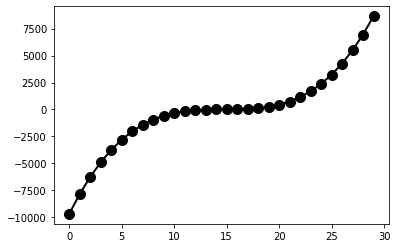

In [24]:
# parameters
order = 3
N = 30
x = cp.array([1., 2., 2., 3.])

# set up problem
t = cp.arange(N, dtype=np.float64)-N//2
LRop = Regression(t, order=order, dtype='float64')
dottest(LRop, N, order+1, verb=True, backend='cupy')

y = LRop*x

plt.figure()
plt.plot(cp.asnumpy(y), '.-k', ms=20, lw=2)

# LSQR solver
xcgls = cgls(LRop, y, cp.zeros(4), damp=1e-10, niter=10 ,show=0)[0]
xcgls = LRop / y

print('x=',x)
print('cgls solution xest=', xcgls)

# First Derivative

Dot test passed, v^T(Opu)=-0.929816 - u^T(Op^Tv)=-0.929816


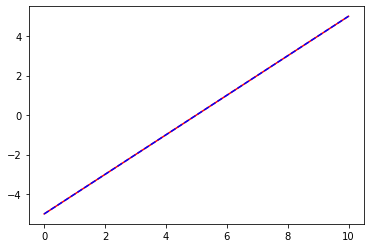

In [25]:
nx = 11
x = cp.arange(nx) - (nx-1)/2

D1op = FirstDerivative(nx, edge=True, dtype='float32')
dottest(D1op,nx,nx, tol=1e-3, verb=True, backend='cupy')

y_lop    = D1op*x
xadj_lop = D1op.H*y_lop

xinv_lop = D1op / y_lop
xinv_lop = cgls(D1op, y_lop, cp.zeros(nx))[0]

plt.figure()
plt.plot(cp.asnumpy(x),'r')
plt.plot(cp.asnumpy(xinv_lop), '--b');

Dot test passed, v^T(Opu)=-11.941393 - u^T(Op^Tv)=-11.941393


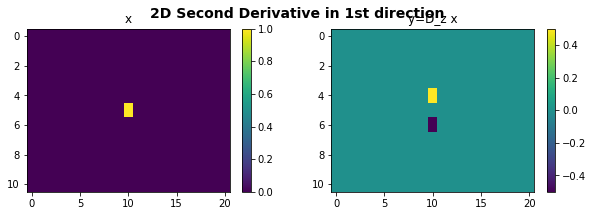

In [26]:
A= cp.zeros((11,21))
A[5,10] = 1

D2op = FirstDerivative(11*21, dims=[11,21], dir=0, edge=True, dtype='float64')
dottest(D2op,11*21,11*21, verb=True, backend='cupy')

B=cp.reshape(D2op*A.ravel(),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('2D Second Derivative in 1st direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A), interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B), interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_z x')
plt.colorbar(imh);

Dot test passed, v^T(Opu)=12.635221 - u^T(Op^Tv)=12.635221


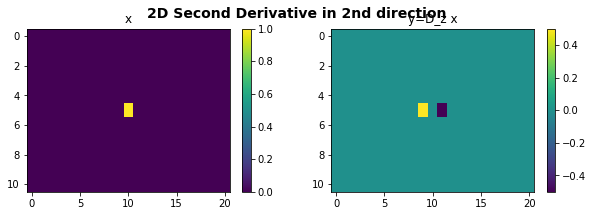

In [27]:
A= cp.zeros((11,21))
A[5,10] = 1

D2op = FirstDerivative(11*21, dims=[11,21], dir=-1, edge=True, dtype='float64')
dottest(D2op,11*21,11*21, verb=True, backend='cupy')

B=np.reshape(D2op*A.ravel(),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('2D Second Derivative in 2nd direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A), interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B), interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_z x')
plt.colorbar(imh);

In [28]:
D2op = FirstDerivative(2001*201, dims=[2001,201], dir=0, edge=True, dtype='float64')

x = np.ones(2001*201)
xc = cp.ones(2001*201)

%timeit -n10 -r3 D2op * x
%timeit -n10 -r3 D2op * xc

10 loops, best of 3: 1.98 ms per loop
10 loops, best of 3: 297 µs per loop


# Second Derivative

In [29]:
x = (cp.arange(11)-5)**2

D2op = SecondDerivative(11, edge=True, dtype='float32')
dottest(D2op, 11,11, verb=True, backend='cupy')

y = D2op*x
print(x)
print(y)

Dot test passed, v^T(Opu)=-5.680314 - u^T(Op^Tv)=-5.680314
[25 16  9  4  1  0  1  4  9 16 25]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


Dot test passed, v^T(Opu)=-3.948833 - u^T(Op^Tv)=-3.948833


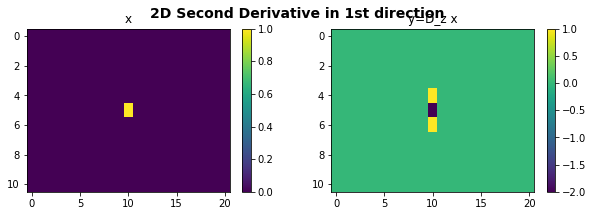

In [30]:
A= cp.zeros((11,21))
A[5,10]=1

D2op = SecondDerivative(11*21, dims =[11,21], dir=0, edge=True, dtype='float64')
dottest(D2op,11*21,11*21, verb=True, backend='cupy')

B=np.reshape(D2op*A.ravel(),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('2D Second Derivative in 1st direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A),interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_z x')
plt.colorbar(imh);

In [31]:
D2op = SecondDerivative(2001*201, dims=[2001,201], dir=0, edge=True, dtype='float64')

x = np.ones(2001*201)
xc = cp.ones(2001*201)

%timeit -n10 -r3 D2op * x
%timeit -n10 -r3 D2op * xc

10 loops, best of 3: 2.09 ms per loop
10 loops, best of 3: 245 µs per loop


# Laplacian

Dot test passed, v^T(Opu)=-15.695272 - u^T(Op^Tv)=-15.695272


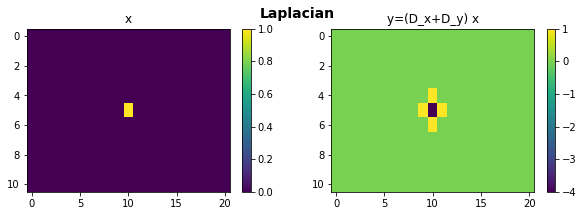

In [32]:
A= cp.zeros((11,21))
A[5,10]=1

L2op = Laplacian([11,21], weights=[1,1], edge=True, dtype='float64')
dottest(L2op,11*21,11*21, verb=True, backend='cupy')


B=np.reshape(L2op*A.ravel(),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Laplacian',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A),interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x+D_y) x')
plt.colorbar(imh);

Dot test passed, v^T(Opu)=74.851098 - u^T(Op^Tv)=74.851107


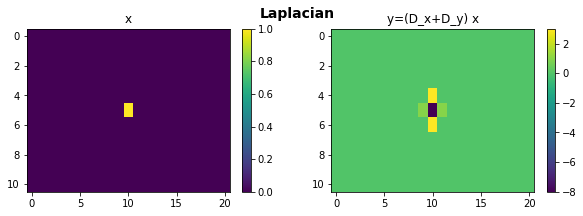

In [33]:
L2op = Laplacian([11,21], weights=[3,1], edge=True, dtype='float32')
dottest(L2op,11*21,11*21, verb=True, backend='cupy')

B=np.reshape(L2op*A.ravel(),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Laplacian',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A),interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x+D_y) x')
plt.colorbar(imh);

In [34]:
D2op = Laplacian([2001,201], dtype='float64')

x = np.ones(2001*201)
xc = cp.ones(2001*201)

%timeit -n10 -r3 D2op * x
%timeit -n10 -r3 D2op * xc

10 loops, best of 3: 6.67 ms per loop
10 loops, best of 3: 292 µs per loop


# Gradient

Dot test passed, v^T(Opu)=11.791960 - u^T(Op^Tv)=11.791960


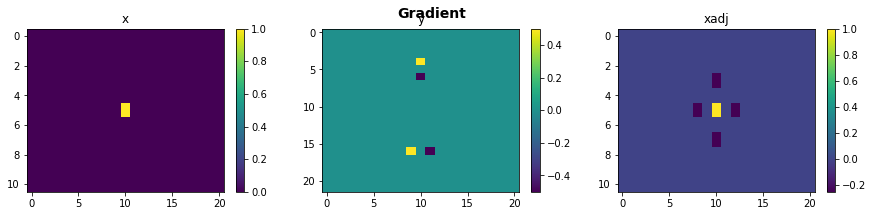

In [35]:
A= cp.zeros((11,21))
A[5,10]=1

G2op = Gradient([11,21], edge=True, dtype='float64')
dottest(G2op,11*21*2,11*21, verb=True, backend='cupy')

B=np.reshape(G2op*A.ravel(),(2*11,21))
C=np.reshape(G2op.H*B.ravel(),(11,21))

fig = plt.figure(figsize=(15,3))
fig.suptitle('Gradient',fontsize=14, fontweight='bold')
ax = plt.subplot(1,3,1)
imh = ax.imshow(cp.asnumpy(A), interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,3,2)
imh = ax.imshow(cp.asnumpy(B), interpolation='nearest')
ax.axis('tight')
ax.set_title('y')
plt.colorbar(imh)
ax = plt.subplot(1,3,3)
imh = ax.imshow(cp.asnumpy(C), interpolation='nearest')
ax.axis('tight')
ax.set_title('xadj')
plt.colorbar(imh);

# Concatenations

Dot test passed, v^T(Opu)=29.195121 - u^T(Op^Tv)=29.195119


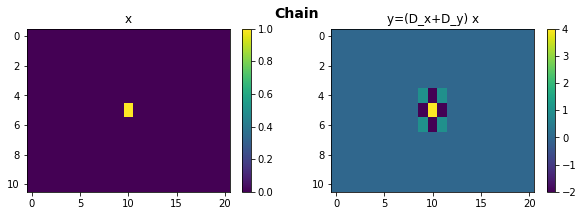

In [36]:
A= cp.zeros((11,21))
A[5,10]=1

D2hop = SecondDerivative(11*21, dims=[11,21], dir=1, dtype='float32')
D2vop = SecondDerivative(11*21, dims=[11,21], dir=0, dtype='float32')

D2op = D2vop*D2hop
dottest(D2op,11*21,11*21, verb=True, backend='cupy')

B=np.reshape(D2op*A.ravel(),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Chain',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A),interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x+D_y) x')
plt.colorbar(imh);

Dot test passed, v^T(Opu)=-12.355013 - u^T(Op^Tv)=-12.355013


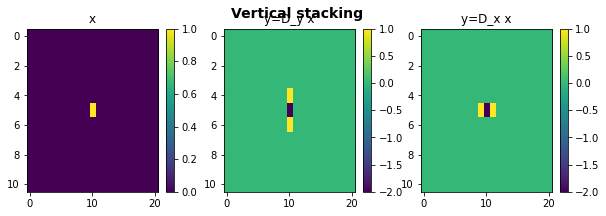

In [37]:
D2hop = SecondDerivative(11*21, dims =[11,21], dir=1, dtype='float64')
D2vop = SecondDerivative(11*21, dims =[11,21], dir=0, dtype='float64')

Vstackop = VStack([D2vop,D2hop])
dottest(Vstackop,2*11*21,11*21, verb=True, backend='cupy')

B=np.reshape(Vstackop*A.ravel(),(11*2,21))
B1 = B[0:11]
B2 = B[11:]

fig = plt.figure(figsize=(10,3))
fig.suptitle('Vertical stacking',fontsize=14, fontweight='bold')
ax = plt.subplot(1,3,1)
imh = ax.imshow(cp.asnumpy(A),interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,3,2)
imh = ax.imshow(cp.asnumpy(B1),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_y x')
plt.colorbar(imh)
ax = plt.subplot(1,3,3)
imh = ax.imshow(cp.asnumpy(B2),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_x x')
plt.colorbar(imh);

Dot test passed, v^T(Opu)=-3.420459 - u^T(Op^Tv)=-3.420459


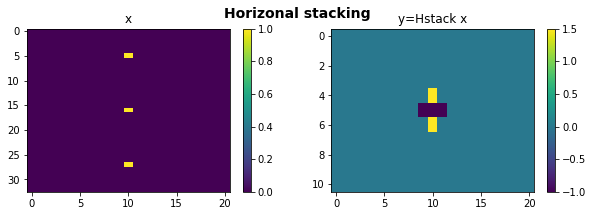

In [38]:
A= cp.zeros((11*3,21))
A[5,10]=1
A[5+11,10]=1
A[5+11*2,10]=1

D2hop = SecondDerivative(11*21, dims =[11,21], dir=1, dtype='float64')
D2vop = SecondDerivative(11*21, dims =[11,21], dir=0, dtype='float64')

Hstackop = HStack([D2vop,0.5*D2vop,-1*D2hop])
dottest(Hstackop,11*21,3*11*21, verb=True, backend='cupy')

B=np.reshape(Hstackop*A.ravel(),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Horizonal stacking',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A),interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=Hstack x')
plt.colorbar(imh);

Dot test passed, v^T(Opu)=-77.383194 - u^T(Op^Tv)=-77.383194


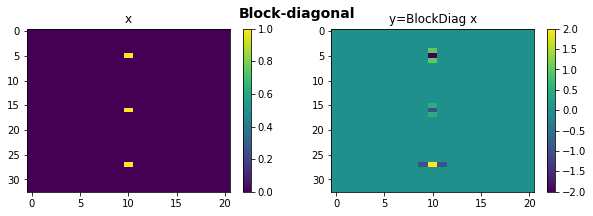

In [39]:
Bop = BlockDiag([D2vop,0.5*D2vop,-1*D2hop])
dottest(Bop,3*11*21,3*11*21, verb=True, backend='cupy')

B=np.reshape(Bop*A.ravel(),(11*3,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Block-diagonal',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(cp.asnumpy(A),interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(cp.asnumpy(B),interpolation='nearest')
ax.axis('tight')
ax.set_title('y=BlockDiag x')
plt.colorbar(imh);

In [40]:
bl = Block([[MatrixMult(cp.ones((5,5))), -2*Identity(5)],
            [Zero(5),                    Diagonal(-2*cp.ones(5))],
            [Identity(5),                Diagonal(-2*cp.ones(5), dtype=np.float64)]])
print(bl)
print(bl*cp.ones(10))

bl = Block([[Identity(5), Zero(5),     Zero(5)],
            [Zero(5),     2*Identity(5), Zero(5)],
            [Zero(5),     Zero(5),     -1*Identity(5)]])

print(bl)
print(bl*cp.ones(15))

<15x10 VStack with dtype=float64>
[ 3.  3.  3.  3.  3. -2. -2. -2. -2. -2. -1. -1. -1. -1. -1.]
<15x15 VStack with dtype=float64>
[ 1.  1.  1.  1.  1.  2.  2.  2.  2.  2. -1. -1. -1. -1. -1.]


# Causal integration

Dot test passed, v^T(Opu)=4.511949 - u^T(Op^Tv)=4.511949
Dot test passed, v^T(Opu)=-5.135702 - u^T(Op^Tv)=-5.135702


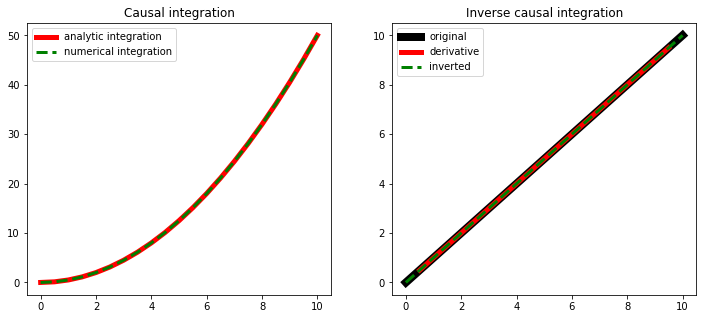

In [41]:
nt = 21
dt = 0.5
ot = 0
t = np.arange(nt)*dt+ot
x = t

Cop = CausalIntegration(nt, sampling=dt, halfcurrent=False)
dottest(Cop,nt,nt, verb=True)

Cop = CausalIntegration(nt, sampling=dt, halfcurrent=True)
dottest(Cop,nt,nt, verb=True)

y    = Cop*x
yana = t**2/2. - t[0]**2/2. + y[0]

xder = np.zeros_like(x)
xder[1:-1] = (y[2:]-y[:-2])/(2*dt)
xinv = Cop / y

# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(cp.asnumpy(t), cp.asnumpy(yana), 'r' , LineWidth=5,   label='analytic integration')
axs[0].plot(cp.asnumpy(t), cp.asnumpy(y), '--g' , LineWidth=3,   label='numerical integration')
axs[0].legend()
axs[0].set_title('Causal integration')

axs[1].plot(cp.asnumpy(t), cp.asnumpy(x), 'k' , LineWidth=8,   label='original')
axs[1].plot(cp.asnumpy(t)[1:-1], cp.asnumpy(xder)[1:-1], 'r' , LineWidth=5,   label='derivative')
axs[1].plot(cp.asnumpy(t), cp.asnumpy(xinv), '--g' , LineWidth=3,   label='inverted')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

Dot test passed, v^T(Opu)=-1.560407 - u^T(Op^Tv)=-1.560407
Dot test passed, v^T(Opu)=29.650852 - u^T(Op^Tv)=29.650852


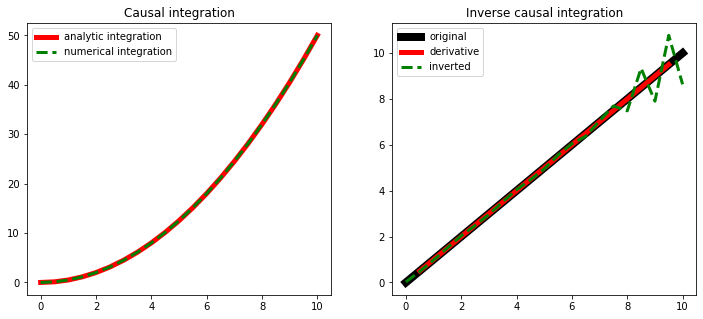

In [42]:
nt = 21
dt = 0.5
ot = 0
t = cp.arange(nt)*dt+ot
x = t

Cop = CausalIntegration(nt, sampling=dt, halfcurrent=False)
dottest(Cop,nt,nt, verb=True, backend='cupy')

Cop = CausalIntegration(nt, sampling=dt, halfcurrent=True)
dottest(Cop,nt,nt, verb=True, backend='cupy')

y    = Cop*x
yana = t**2/2. - t[0]**2/2. + y[0]

xder = cp.zeros_like(x)
xder[1:-1] = (y[2:]-y[:-2])/(2*dt)
xinv = Cop.div(y, 20)

# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(cp.asnumpy(t), cp.asnumpy(yana), 'r' , LineWidth=5,   label='analytic integration')
axs[0].plot(cp.asnumpy(t), cp.asnumpy(y), '--g' , LineWidth=3,   label='numerical integration')
axs[0].legend()
axs[0].set_title('Causal integration')

axs[1].plot(cp.asnumpy(t), cp.asnumpy(x), 'k' , LineWidth=8,   label='original')
axs[1].plot(cp.asnumpy(t)[1:-1], cp.asnumpy(xder)[1:-1], 'r' , LineWidth=5,   label='derivative')
axs[1].plot(cp.asnumpy(t), cp.asnumpy(xinv), '--g' , LineWidth=3,   label='inverted')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

Dot test passed, v^T(Opu)=86.463156 - u^T(Op^Tv)=86.463156
Dot test passed, v^T(Opu)=15.995023 - u^T(Op^Tv)=15.995023


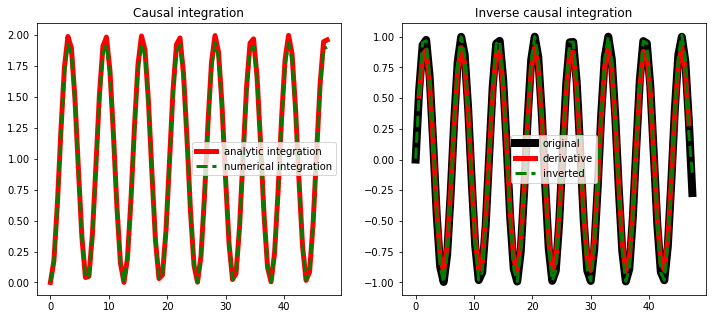

In [43]:
nt = 80
dt = .6
ot = 0
t = cp.arange(nt)*dt+ot
x = cp.sin(t)

Cop = CausalIntegration(nt,sampling=dt, halfcurrent=False)
dottest(Cop,nt,nt, verb=True, backend='cupy')

Cop = CausalIntegration(nt,sampling=dt, halfcurrent=True)
dottest(Cop,nt,nt, verb=True, backend='cupy')

yana = -cp.cos(t) + cp.cos(t[0])
y    = Cop*x

xinv = Cop / y

# Numerical derivative
Dop = FirstDerivative(nt, sampling=dt)
xder = Dop*y

# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(cp.asnumpy(t), cp.asnumpy(yana), 'r' , LineWidth=5,   label='analytic integration')
axs[0].plot(cp.asnumpy(t), cp.asnumpy(y), '--g' , LineWidth=3,   label='numerical integration')
axs[0].legend()
axs[0].set_title('Causal integration')

axs[1].plot(cp.asnumpy(t), cp.asnumpy(x), 'k' , LineWidth=8,   label='original')
axs[1].plot(cp.asnumpy(t)[1:-1], cp.asnumpy(xder)[1:-1], 'r' , LineWidth=5,   label='derivative')
axs[1].plot(cp.asnumpy(t), cp.asnumpy(xinv), '--g' , LineWidth=3,   label='inverted')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

Dot test passed, v^T(Opu)=-58.444407 - u^T(Op^Tv)=-58.444407


(-0.5, 40.5, 79.5, -0.5)

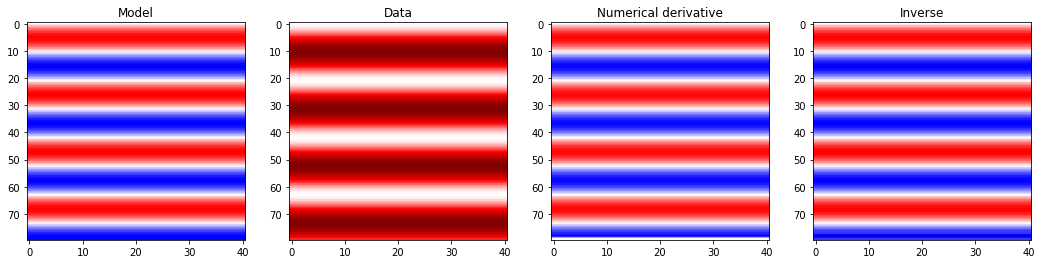

In [44]:
nt, nx = 80, 41
dt = .3
ot = 0
t = cp.arange(nt)*dt+ot
x = cp.outer(cp.sin(t), cp.ones(nx))

Cop = CausalIntegration(nt*nx, dims=(nt, nx), sampling=dt, dir=0,  halfcurrent=True)
dottest(Cop, nt*nx, nt*nx, verb=True, backend='cupy')

# numerical integration
y = Cop*x.flatten()
y = y.reshape(nt, nx)

#analytical integration 
yana = cp.outer(-cp.cos(t), cp.ones(nx)) + cp.cos(t[0])
yana = yana.reshape(nt, nx)

# Numerical derivative
Dop = FirstDerivative(nt*nx, dims=(nt, nx), dir=0, sampling=dt)
xder = Dop*y.flatten()
xder = xder.reshape(nt, nx)

xinv = Cop / y.flatten()
xinv = xinv.reshape(nt, nx)

# Visualize data and inversion
vmax = 2*np.max(np.abs(x))        
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
axs[0].imshow(cp.asnumpy(x), cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(y), cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(xder), cmap='seismic', vmin=-vmax, vmax=vmax)
axs[2].set_title('Numerical derivative')
axs[2].axis('tight')
axs[3].imshow(cp.asnumpy(xinv), cmap='seismic', vmin=-vmax, vmax=vmax)
axs[3].set_title('Inverse')
axs[3].axis('tight')

# Flip

Dot test passed, v^T(Opu)=-1.741183 - u^T(Op^Tv)=-1.741183


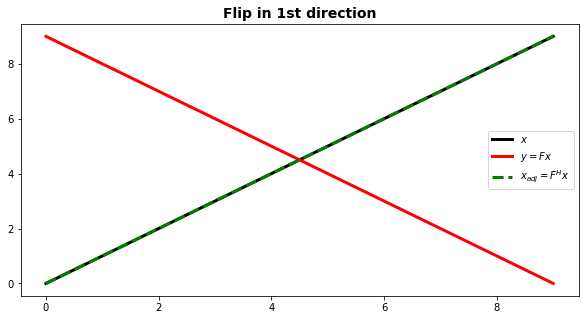

In [45]:
nt = 10
x = cp.arange(nt)

Fop = Flip(nt)
dottest(Fop, nt, nt, verb=True, backend='cupy')

y = Fop*x
xadj = Fop.H*y

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label=r'$x$')
plt.plot(cp.asnumpy(y), 'r', lw=3, label=r'$y=Fx$')
plt.plot(cp.asnumpy(xadj), '--g', lw=3, label=r'$x_{adj} = F^H x$')
plt.title('Flip in 1st direction', fontsize=14, fontweight='bold')
plt.legend()

Dot test passed, v^T(Opu)=-1.280934 - u^T(Op^Tv)=-1.280934


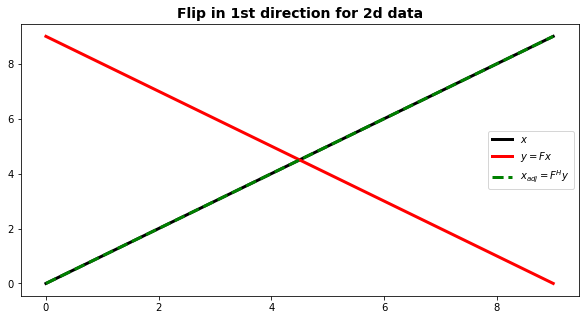

In [46]:
nt, nx = 10, 5
x = cp.outer(cp.arange(nt), cp.ones(nx))

Fop = Flip(nt*nx, dims=(nt, nx), dir=0)
dottest(Fop, nt*nx, nt*nx, verb=True, backend='cupy')

y = Fop*x.flatten()
xadj = Fop.H*y.flatten()
y = y.reshape(nt, nx)
xadj = xadj.reshape(nt, nx)

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x)[:, nx//2], 'k', lw=3, label=r'$x$')
plt.plot(cp.asnumpy(y)[:, nx//2], 'r', lw=3, label=r'$y=Fx$')
plt.plot(cp.asnumpy(xadj)[:, nx//2], '--g', lw=3, label=r'$x_{adj} = F^H y$')
plt.title('Flip in 1st direction for 2d data', fontsize=14, fontweight='bold')
plt.legend();

Dot test passed, v^T(Opu)=0.519144 - u^T(Op^Tv)=0.519144


(-0.5, 4.5, 9.5, -0.5)

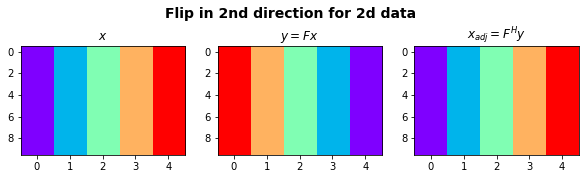

In [47]:
nt, nx = 10, 5
x = cp.outer(cp.ones(nt), cp.arange(nx))

Fop = Flip(nt*nx, dims=(nt, nx), dir=1)
dottest(Fop, nt*nx, nt*nx, verb=True, backend='cupy')

y = Fop*x.flatten()
xadj = Fop.H*y.flatten()
y = y.reshape(nt, nx)
xadj = xadj.reshape(nt, nx)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Flip in 2nd direction for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(cp.asnumpy(x), cmap='rainbow')
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(y), cmap='rainbow')
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(xadj), cmap='rainbow')
axs[2].set_title(r'$x_{adj} = F^H y$')
axs[2].axis('tight')

Dot test passed, v^T(Opu)=-1.775211 - u^T(Op^Tv)=-1.775211


(-0.5, 3.5, 2.5, -0.5)

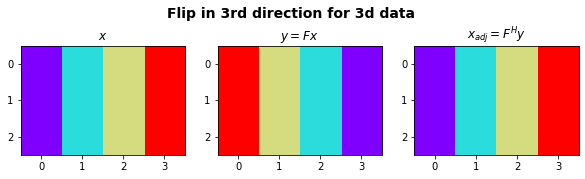

In [48]:
nt, nx, ny = 2, 3, 4
x = cp.outer(cp.ones(nt), cp.ones(nx))[:, :, np.newaxis] * cp.arange(ny)

Fop = Flip(nt*nx*ny, dims=(nt, nx, ny), dir=2)
dottest(Fop, nt*nx*ny, nt*nx*ny, verb=True, backend='cupy')

y = Fop*x.flatten()
xadj = Fop.H*y.flatten()
y = y.reshape(nt, nx, ny)
xadj = xadj.reshape(nt, nx, ny)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Flip in 3rd direction for 3d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(cp.asnumpy(x)[nt//2], cmap='rainbow')
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(y)[nt//2], cmap='rainbow')
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(xadj)[nt//2], cmap='rainbow')
axs[2].set_title(r'$x_{adj} = F^H y$')
axs[2].axis('tight')

# Pad

In [49]:
dims = 10
pad = (10, 3)

Pop = Pad(dims, pad)
dottest(Pop, dims+pad[0]+pad[1], dims, verb=True, backend='cupy')

x = cp.arange(dims)+1.

y = Pop*x
xadj = Pop.H*y
xinv = Pop / y

print(x)
print(y)
print(xadj)
print(xinv)

Dot test passed, v^T(Opu)=-0.629090 - u^T(Op^Tv)=-0.629090
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10.  0.  0.  0.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Dot test passed, v^T(Opu)=0.042858 - u^T(Op^Tv)=0.042858


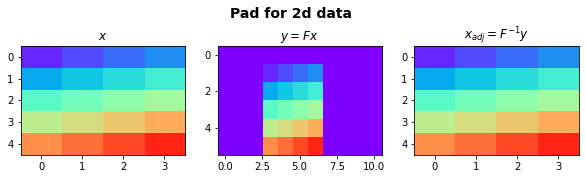

In [50]:
dims = (5, 4)
pad = ((1, 0), (3, 4))

Pop = Pad(dims, pad)
dottest(Pop, Pop.shape[0], Pop.shape[1], verb=True, backend='cupy')

x = (cp.arange(cp.prod(cp.array(dims)))+1.).reshape(dims)

y = Pop*x.ravel()
xadj = Pop.H*y
xinv = Pop / y

y = y.reshape(Pop.dimsd)
xadj = xadj.reshape(dims)
xinv = xinv.reshape(dims)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Pad for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(cp.asnumpy(x), cmap='rainbow', vmin=0, vmax=np.prod(np.array(dims))+1)
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(y), cmap='rainbow', vmin=0, vmax=np.prod(np.array(dims))+1)
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(xadj), cmap='rainbow', vmin=0, vmax=np.prod(np.array(dims))+1)
axs[2].set_title(r'$x_{adj} = F^{-1} y$')
axs[2].axis('tight');

# Roll

In [51]:
n = 10
x = cp.arange(n) + 1j * cp.arange(n)

Rop = Roll(n, shift=2, dtype='float32')
dottest(Rop, n, n, verb=True, backend='cupy')

y = Rop * x
xadj = Rop.H * y
print(x)
print(y)
print(xadj)

Dot test passed, v^T(Opu)=2.705273 - u^T(Op^Tv)=2.705273
[0.+0.j 1.+1.j 2.+2.j 3.+3.j 4.+4.j 5.+5.j 6.+6.j 7.+7.j 8.+8.j 9.+9.j]
[8.+8.j 9.+9.j 0.+0.j 1.+1.j 2.+2.j 3.+3.j 4.+4.j 5.+5.j 6.+6.j 7.+7.j]
[0.+0.j 1.+1.j 2.+2.j 3.+3.j 4.+4.j 5.+5.j 6.+6.j 7.+7.j 8.+8.j 9.+9.j]


In [52]:
ny, nx = 10, 5
x = cp.outer(cp.arange(ny), cp.ones(nx)) 
Rop = Roll(ny * nx, dims=(ny, nx), dir=0, shift=-2, dtype='float32')
dottest(Rop, ny * nx, ny * nx, verb=True)

y = Rop * x.flatten()
xadj = Rop.H * y
print(x)
print(y.reshape(ny, nx))
print(xadj.reshape(ny, nx))

Dot test passed, v^T(Opu)=8.392037 - u^T(Op^Tv)=8.392037
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9.]]
[[2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9.]]


# Symmetrize

Dot test passed, v^T(Opu)=5.881028 - u^T(Op^Tv)=5.881028


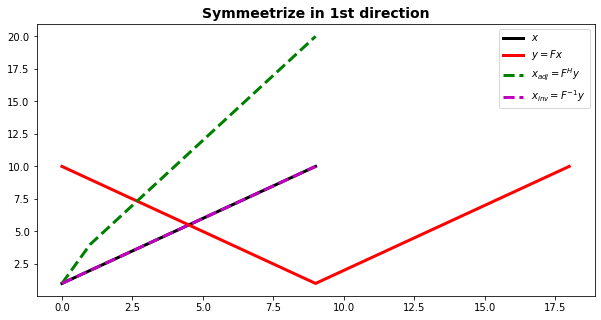

In [53]:
nt = 10
x = cp.arange(nt)+1.

Sop = Symmetrize(nt)
dottest(Sop, nt*2-1, nt, verb=True, backend='cupy')

y = Sop*x
xadj = Sop.H*y
xinv = Sop / y

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label=r'$x$')
plt.plot(cp.asnumpy(y), 'r', lw=3, label=r'$y=Fx$')
plt.plot(cp.asnumpy(xadj), '--g', lw=3, label=r'$x_{adj} = F^H y$')
plt.plot(cp.asnumpy(xinv), '--m', lw=3, label=r'$x_{inv} = F^{-1} y$')
plt.title('Symmeetrize in 1st direction', fontsize=14, fontweight='bold')
plt.legend();

Dot test passed, v^T(Opu)=7.285387 - u^T(Op^Tv)=7.285387


(-0.5, 5.5, 9.5, -0.5)

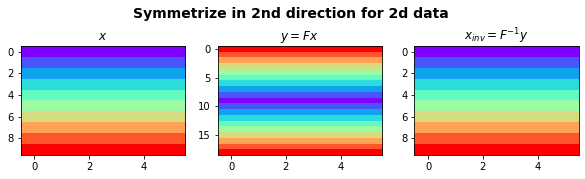

In [54]:
nt, nx = 10, 6
x = cp.outer(cp.arange(nt), cp.ones(nx))

Sop = Symmetrize(nt*nx, dims=(nt, nx), dir=0)
dottest(Sop, (nt*2-1)*nx, nt*nx, verb=True, backend='cupy')

y = Sop*x.flatten()
xadj = Sop.H*y.flatten()
xinv = Sop / y
y = y.reshape(2*nt-1, nx)
xadj = xadj.reshape(nt, nx)
xinv = xinv.reshape(nt, nx)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Symmetrize in 2nd direction for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(cp.asnumpy(x), cmap='rainbow', vmin=0, vmax=9)
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(y), cmap='rainbow', vmin=0, vmax=9)
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(xinv), cmap='rainbow', vmin=0, vmax=9)
axs[2].set_title(r'$x_{inv} = F^{-1} y$')
axs[2].axis('tight')

# Kronecker Product

In [55]:
n1, m1 = 10, 5
n2, m2 = 20, 3
A = cp.random.normal(0, 1, (n1, m1))
B = 5*cp.ones((n2, m2))
x = cp.ones(m1*m2)

AB = cp.kron(A, B)
y = cp.dot(AB, x)
xadj = cp.dot(AB.T, y)

Aop = MatrixMult(A)
Bop = MatrixMult(B)

ABop = Kronecker(Aop, Bop)
dottest(ABop, n1*n2, m1*m2, verb=True, backend='cupy')

yop = ABop*x
xadjop = ABop.H*yop

xinv = lsqr(cp.asnumpy(AB), cp.asnumpy(y))[0]
xinvop = ABop / yop

print(x)
print(xinv)
print(xinvop)

Dot test passed, v^T(Opu)=-133.424054 - u^T(Op^Tv)=-133.424054
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<231x231 Kronecker with dtype=float64>


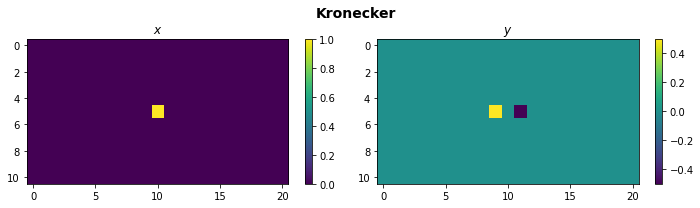

In [56]:
Nv, Nh = 11, 21

Iop = Identity(Nv, dtype='float32')
D2hop = FirstDerivative(Nh, dtype='float32')

X = cp.zeros((Nv, Nh))
X[Nv//2, Nh//2] = 1
D2hop = Kronecker(Iop, D2hop)
print(D2hop)

Y = D2hop * X.ravel()
Y = Y.reshape(Nv, Nh)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Kronecker', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(cp.asnumpy(X), interpolation='nearest')
axs[0].axis('tight')
axs[0].set_title(r'$x$')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(cp.asnumpy(Y), interpolation='nearest')
axs[1].axis('tight')
axs[1].set_title(r'$y$')
plt.colorbar(im, ax=axs[1])
plt.tight_layout()
plt.subplots_adjust(top=0.8);

<231x231 Kronecker with dtype=float64>


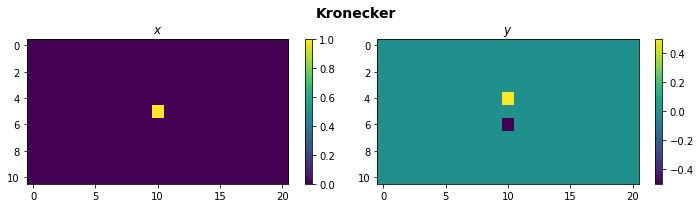

In [57]:
Nv, Nh = 11, 21

Iop = Identity(Nh, dtype='float32')
D2hop = FirstDerivative(Nv, dtype='float32')

X = cp.zeros((Nv, Nh))
X[Nv//2, Nh//2] = 1
D2hop = Kronecker(D2hop, Iop)
print(D2hop)

Y = D2hop*X.ravel()
Y = Y.reshape(Nv, Nh)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Kronecker', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(cp.asnumpy(X), interpolation='nearest')
axs[0].axis('tight')
axs[0].set_title(r'$x$')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(cp.asnumpy(Y), interpolation='nearest')
axs[1].axis('tight')
axs[1].set_title(r'$y$')
plt.colorbar(im, ax=axs[1])
plt.tight_layout()
plt.subplots_adjust(top=0.8);

# Restriction

Dot test passed, v^T(Opu)=-19.329655 - u^T(Op^Tv)=-19.329655


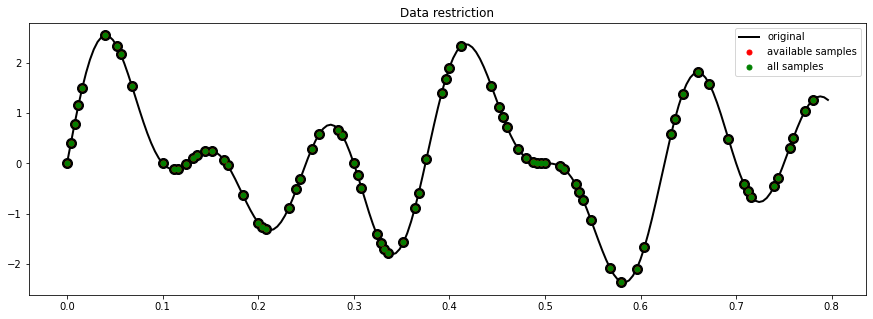

In [58]:
# Signal creation
freqs = [ 5., 3., 8.]

N=200
dt=0.004
t = cp.arange(N)*dt
x = cp.zeros(N)

for freq in freqs:
    x = x + cp.sin(2*np.pi*freq*t)
    
# subsampling locations
perc_subsampling=0.4
Nsub=int(N*perc_subsampling)

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop, Nsub, N, verb=True, backend='cupy')

y = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(cp.asnumpy(t), cp.asnumpy(x), 'k' , LineWidth=2,   label='original')
plt.plot(cp.asnumpy(t)[iava], cp.asnumpy(x)[iava], '.k', MarkerSize=20)
plt.plot(cp.asnumpy(t)[iava], cp.asnumpy(y), '.r', MarkerSize=10, label='available samples')
plt.plot(cp.asnumpy(t), ymask, '.g', MarkerSize=10, label='all samples')
plt.legend()
plt.title('Data restriction');

# Transpose

Dot test passed, v^T(Opu)=27.977384 - u^T(Op^Tv)=27.977384


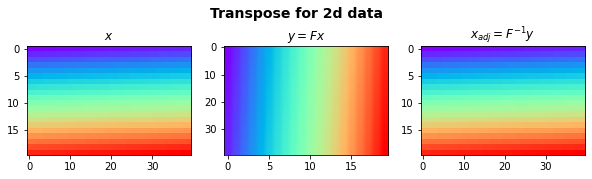

In [59]:
dims = (20, 40)
x = cp.arange(800).reshape(dims)

Top = Transpose(dims=dims, axes=(1,0))
dottest(Top, np.prod(dims), np.prod(dims), verb=True, backend='cupy')

y = Top * x.ravel()
xadj = Top.H * y
y = y.reshape(Top.dimsd)
xadj = xadj.reshape(Top.dims)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Transpose for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(cp.asnumpy(x), cmap='rainbow', vmin=0, vmax=800)
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(y), cmap='rainbow', vmin=0, vmax=800)
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(xadj), cmap='rainbow', vmin=0, vmax=800)
axs[2].set_title(r'$x_{adj} = F^{-1} y$')
axs[2].axis('tight');

In [60]:
dims = (10, 5, 4)
x = cp.arange(np.prod(dims)).reshape(dims)

Top = Transpose(dims=dims, axes=(2, 1, 0))
dottest(Top, np.prod(dims), np.prod(dims), verb=True, backend='cupy')

y = Top * x.ravel()
xadj = Top.H * y
y = y.reshape(Top.dimsd)
xadj = xadj.reshape(Top.dims)

print(cp.allclose(x, xadj))

Dot test passed, v^T(Opu)=-11.578780 - u^T(Op^Tv)=-11.578780
True


# Function operator

In [61]:
G = cp.random.normal(0, 1, (10, 5))

def forward_f(x):
    return G @ x
def adjoint_f(x):
    return G.T @ x
Fop = FunctionOperator(forward_f, adjoint_f, 10, 5)

x = cp.ones(5)
y = Fop @ x
Fop.H @ y

array([17.37070981, 14.63063681, 12.2101046 , 18.28843123, 10.13114923])

Directional derivatives

In [62]:
Fdop = FirstDirectionalDerivative((20, 10),
                                  v=cp.sqrt(2.)/2. * cp.ones(2),
                                  sampling=(1., 1.), kind='centered',
                                  dtype='float32')
dottest(Fdop, 200, 200, tol=1e-3, verb=True, backend='cupy')

Fdop = SecondDirectionalDerivative((20, 10),
                                   v=cp.sqrt(2.)/2. * cp.ones(2),
                                   sampling=(1., 1.), dtype='float32')
dottest(Fdop, 200, 200, tol=1e-3, verb=True, backend='cupy')

Dot test passed, v^T(Opu)=-3.991129 - u^T(Op^Tv)=-3.991130
Dot test passed, v^T(Opu)=11.710500 - u^T(Op^Tv)=11.710500


True